In [1]:
# added by Hari to link drive with colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN

/content/drive/My Drive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN


# Imports



In [3]:
import h5py
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from utils import *
from BoxHead import *
from MaskHead import *
from rpn import *
from dataset import *
from pretrained_models import *

In [4]:
# Build dataset
torch.manual_seed(42)
np.random.seed(42)

# Data Paths


In [5]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
    
paths = [imgs_path, masks_path, labels_path, bboxes_path]

# Visualize Ground Truth

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/drive/My Drive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN/BoxHead.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ordered_idx = torch.tensor(indexes.nonzero(), device='cuda')


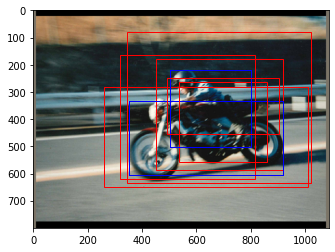

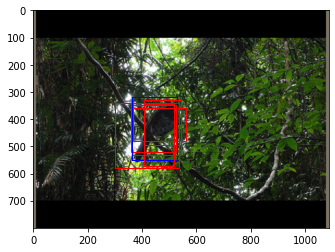

In [6]:
if __name__ =='__main__':
    # load the data into data.Dataset
    dataset = BuildDataset(paths)
    device = 'cuda'

    # build dataloader
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    train_size_final = int(train_size * 0.9)
    val_size = train_size - train_size_final

    # random split 
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])

    batch_size = 4
    test_batch_size = 1
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
    train_loader = train_build_loader.loader()

    test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = test_build_loader.loader()

    val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = val_build_loader.loader()

    model = BoxHead()
    #lr= 7e-4
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #num_epochs = 50

    model.to(device)

    # import image list
    from torchvision.models.detection.image_list import ImageList

    pretrained_path='/content/drive/My Drive/Colab Notebooks/CIS 680/HW4_PartB/checkpoint680.pth'  
    backbone, rpn = pretrained_models_680(pretrained_path)
    k_train = 10
    k_eval = 20
    keep_topK= k_train

    for iter, batch in enumerate(test_loader, 0):
      images = batch['images']
      images = images.type(torch.FloatTensor)
      images = images.to(device)

      labels = [l.to(device) for l in batch['labels']]
      bboxes = [b.to(device) for b in batch['bbox']]

      # Take the features from the backbone
      backout = backbone(images)

      # The RPN implementation takes as first argument the following image list
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])

      # Then we pass the image list and the backbone output through the rpn
      rpnout = rpn(im_lis, backout)

      #The final output is
      # A list of proposal tensors: list:len(bz){(keep_topK,4)}
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

      # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
      fpn_feat_list= list(backout.values())

      # apply ROI align to proposals
      #%timeit model.MultiScaleRoiAlign(fpn_feat_list, proposals)
      feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

      # create ground truth
      # %timeit model.create_ground_truth_batch(proposals, labels, bboxes)

      label_targets, regr_targets = model.create_ground_truth_batch(proposals, labels, bboxes)

      foreground_idx = label_targets.nonzero()[:,0]
      foreground_boxes = regr_targets[foreground_idx]
      foreground_proposals = proposals[0][foreground_idx]

      box = output_decodingd(foreground_boxes,foreground_proposals)
      
      # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
      images = transforms.functional.normalize(images,
                                                    [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                    [1/0.229, 1/0.224, 1/0.225], inplace=False)
      fig,ax=plt.subplots(1,1)
      images = images.squeeze() # batch size 1
      ax.imshow(images.cpu().numpy().transpose(1,2,0))
      
      #find_cor=(flatten_gt==1).nonzero()
      #find_neg=(flatten_gt==-1).nonzero()

            
      for num, coord in enumerate(box):
        #coord=torch.tensor(decoded_coord[elem,:]).view(-1)
        #anchor=torch.tensor(flatten_anchors[elem,:]).view(-1)
        prop = foreground_proposals[num]

        rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color='b')
        ax.add_patch(rect)
        rect=patches.Rectangle((prop[0],prop[1]),prop[2]-prop[0],prop[3]-prop[1],fill=False,color='r')
        ax.add_patch(rect)

      plt.show()

      if(iter>0):
          break


# Main Train

In [14]:
if __name__ =='__main__':
    # load the data into data.Dataset
    dataset = BuildDataset(paths)
    device = 'cuda'
    torch.manual_seed(42)
    np.random.seed(42)

    # build dataloader
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    train_size_final = int(train_size * 0.9)
    val_size = train_size - train_size_final

    # random split 
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])

    batch_size = 1
    test_batch_size = 1
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
    train_loader = train_build_loader.loader()

    test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = test_build_loader.loader()

    val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = val_build_loader.loader()

    boxhead = BoxHead()
    maskhead = MaskHead()
    lr= 7e-4
    optimizer = torch.optim.Adam(maskhead.parameters(), lr=lr)
    num_epochs = 51

    boxhead.to(device)
    maskhead.to(device)

    load = True
    if load:
      checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN/boxhead_checkpoints/model_epoch_45.pth')
      print(checkpoint)
      boxhead.load_state_dict(checkpoint['model_state_dict'])
    boxhead.eval()
    # initiliaze pretrained models
    pretrained_path='/content/drive/My Drive/Colab Notebooks/CIS 680/HW4_PartB/checkpoint680.pth'  
    backbone, rpn = pretrained_models_680(pretrained_path)
    k_train = 1000
    k_eval = 20
    keep_topK= k_train

    # import image list
    from torchvision.models.detection.image_list import ImageList

    train_loss = []
    val_loss = []


    epoch_time = time.time()

    for epoch in range(num_epochs):
      print('Epoch : {}/{}..............'.format(epoch, num_epochs))
      running_loss = 0

      # validation loss
      val_running_loss = 0
      
      # train loop
      maskhead.train()
      for iter, batch in enumerate(train_loader, 0):
        images = batch['images']
        images = images.type(torch.FloatTensor)
        images = images.to(device)

        labels = [l.to(device) for l in batch['labels']]
        bboxes = [b.to(device) for b in batch['bbox']]
        masks = [m.to(device) for m in batch['masks']]

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])

        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())
        
        # create ground truth
        # apply ROI align to proposals
        feature_vectors = boxhead.MultiScaleRoiAlign(fpn_feat_list, proposals, P=7)
        label_targets, regr_targets = boxhead.create_ground_truth_batch(proposals, labels, bboxes)

        # forward pass through boxhead
        label_preds, regr_preds = boxhead.forward(feature_vectors)

        # create mask rcnn ground truths
        label_preds = F.softmax(label_preds, dim=1)

        mask_boxes, mask_scores, mask_labels, mask_gt_masks = maskhead.preprocess_ground_truth_creation(label_preds, regr_preds, proposals, labels, bboxes, masks, IOU_thresh=0.5, keep_num_preNMS=700, keep_num_postNMS=100)
        if len(mask_boxes[0]) == 0:
          continue

        mask_feature_vectors = MultiScaleRoiAlign(fpn_feat_list, mask_boxes, P=14)

        # zero gradients
        optimizer.zero_grad()
        # pass through forward
        mask_output = maskhead.forward(mask_feature_vectors)

        # calculate loss
        mask_labels = maskhead.flatten_inputs(mask_labels)
        mask_gt_masks = maskhead.flatten_inputs(mask_gt_masks)
        loss = maskhead.compute_loss(mask_output, mask_labels, mask_gt_masks)

        # backward pass
        loss.backward()
        # weight update
        optimizer.step()

        running_loss += loss.item()
        num_batches_train = iter + 1

      epoch_train_loss = running_loss / num_batches_train
      train_loss.append(epoch_train_loss)

      print('total training loss', epoch_train_loss)

      # validation
      maskhead.eval()
      with torch.no_grad():
        for i, batch in enumerate(val_loader,0):
            images = batch['images']
            images = images.type(torch.FloatTensor)
            images = images.to(device)

            bboxes = [b.to(device) for b in batch['bbox']]
            labels = [l.to(device) for l in batch['labels']]
            masks = [m.to(device) for m in batch['masks']]

            # Take the features from the backbone
            backout = backbone(images)

            # Pass the image list and the backbone output through the rpn
            im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
            rpnout = rpn(im_lis, backout)

            # A list of proposal tensors: list:len(bz){(keep_topK,4)}
            proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

            # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
            fpn_feat_list = list(backout.values())
            feature_vectors = boxhead.MultiScaleRoiAlign(fpn_feat_list, proposals)

            label_targets, regr_targets = boxhead.create_ground_truth_batch(proposals, labels, bboxes)

            # forward pass through boxhead
            label_preds, regr_preds = boxhead.forward(feature_vectors)
            label_preds = F.softmax(label_preds, dim=1)

            mask_boxes, mask_scores, mask_labels, mask_gt_masks = maskhead.preprocess_ground_truth_creation(label_preds, regr_preds, proposals, labels, bboxes, masks, IOU_thresh=0.5, keep_num_preNMS=700, keep_num_postNMS=100)
            if len(mask_boxes[0]) == 0:
              continue

            mask_feature_vectors = MultiScaleRoiAlign(fpn_feat_list, mask_boxes, P=14)

            # pass through forward
            mask_output = maskhead.forward(mask_feature_vectors)

            # calculate loss
            mask_labels = maskhead.flatten_inputs(mask_labels)
            mask_gt_masks = maskhead.flatten_inputs(mask_gt_masks)
            loss = maskhead.compute_loss(mask_output, mask_labels, mask_gt_masks)

            val_running_loss += loss.item()

        val_loss.append(val_running_loss/ len(val_loader))

        print('total validation loss', val_running_loss/ len(val_loader))

      
      print(f"Epoch time:{time.time() - epoch_time:.2f} sec")
      epoch_time = time.time()

      # save model
      if epoch % 5 == 0:
        torch.save(maskhead.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/maskhead_checkpoints/model_epoch_' + str(epoch) + '.pth')
        torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/maskhead_checkpoints/optimizer_epoch_' + str(epoch) + '.pth')
        state_save_path = '/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/maskhead_checkpoints' + str(epoch)
        torch.save({
          'epoch': epoch,
          'model_state_dict': maskhead.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': train_loss,
          'val_loss': val_loss,
          }, state_save_path)

OrderedDict([('intermediate_layer.0.weight', tensor([[ 9.9103e-04, -6.9148e-06,  1.9915e-03,  ..., -1.3908e-03,
         -4.4561e-03, -7.4909e-03],
        [ 2.0034e-03, -9.5669e-04, -1.2352e-02,  ..., -1.1033e-02,
          1.9531e-03, -1.0113e-02],
        [-1.5863e-02, -1.1154e-02, -1.5902e-02,  ...,  3.6522e-03,
          1.0014e-02, -5.4083e-03],
        ...,
        [-2.3641e-02, -4.9853e-02,  3.1327e-02,  ...,  5.4050e-03,
          5.6456e-02,  3.3861e-02],
        [-4.6010e-03, -5.1577e-03, -1.0818e-02,  ...,  6.6260e-03,
          1.2092e-02, -6.8819e-04],
        [-2.3320e-02, -3.1457e-03, -1.6500e-02,  ...,  1.0205e-02,
          1.0962e-02,  9.1910e-03]], device='cuda:0')), ('intermediate_layer.0.bias', tensor([-0.0041,  0.0032, -0.0115,  ..., -0.0780, -0.0061, -0.0150],
       device='cuda:0')), ('intermediate_layer.2.weight', tensor([[ 0.0222,  0.0212,  0.0201,  ..., -0.0259, -0.0014,  0.0275],
        [-0.0050, -0.0135, -0.0298,  ..., -0.0178,  0.0057, -0.0005],
       

KeyError: ignored

In [ ]:
# Plotting

# Training 
fig = plt.figure(1)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg loss per epoch, training')
plt.savefig('total_train.png')

# Validation
fig = plt.figure(2)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg loss per epoch, validation')
plt.savefig('total_val.png')


# Main Inference

In [ ]:
from BoxHead import *
# Set flags for plotting
plot_raw_output = False
plot_postprocess_output = True

device = 'cuda'

# build dataloader
dataset = BuildDataset(paths)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
train_size_final = int(train_size * 0.9)
val_size = train_size - train_size_final

# random split 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])

batch_size = 4
test_batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = val_build_loader.loader()

# initiliaze pretrained models and dataset
pretrained_path='/content/drive/My Drive/Colab Notebooks/CIS 680/HW4_PartB/checkpoint680.pth' 
backbone, rpn = pretrained_models_680(pretrained_path)
from torchvision.models.detection.image_list import ImageList

# load model

load = True
if load:
  #checkpoint_epoch = 55
  model_infer = BoxHead()
  model_infer.to(device)
  checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/boxhead_checkpoints/run1/run1_epoch_45')
  model_infer.load_state_dict(checkpoint['model_state_dict'])

else: 
  model_infer = model

# evaluate
keep_topK = 200

model_infer.eval()
with torch.no_grad():
  for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    images = images.type(torch.FloatTensor)
    images = images.to(device)
    gt_labels = [l.to(device) for l in batch['labels']]
    gt_bboxes = [b.to(device) for b in batch['bbox']]

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list = list(backout.values())
    feature_vectors = model_infer.MultiScaleRoiAlign(fpn_feat_list, proposals)
    label_targets, regressor_targets = model_infer.create_ground_truth_batch(proposals, gt_labels, gt_bboxes)
    label_preds, regressor_preds = model_infer.forward(feature_vectors)

    # Pass through softmax for getting predictions
    label_preds = F.softmax(label_preds, dim=1)

    # Postprocessing 
    boxes_nms, scores_nms, labels_nms = model_infer.postprocess_detections(label_preds, regressor_preds, proposals, conf_thresh=0.50, keep_num_preNMS=50, keep_num_postNMS=2)


    images = transforms.functional.normalize(images,
                                                      [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                      [1/0.229, 1/0.224, 1/0.225], inplace=False)
    for image in images:

      if plot_raw_output:
        fig , ax = plt.subplots(1,1)
        image = image.squeeze(0) 
        ax.imshow(image.permute(1,2,0).cpu())
        box_ind_to_plot = label_preds.argmax(dim=1)

        i = 0
        for c, coords in zip(box_ind_to_plot,regressor_preds):
          color = ['b', 'g', 'r']
          proposal = proposals[0][i]
          if c == 0:
            i += 1
            continue
          coord = coords[4*(c-1):4*(c-1) + 4]
          col=color[c-1]
          coord = output_decodingd(coord.unsqueeze(0), proposal.unsqueeze(0))
          coord = coord.squeeze(0)

          rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
          ax.add_patch(rect)
          i += 1

      if plot_postprocess_output:
        fig , ax = plt.subplots(1,1)
        image = image.squeeze(0) 
        ax.imshow(image.permute(1,2,0).cpu())

        i = 0
        for c, coords in zip(labels_nms,boxes_nms):
          color = ['b', 'g', 'r']
          proposal = proposals[0][i]
          if c == 0:
            continue

          coord = coords
       
          col=color[int(c.item())-1]
          rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
          ax.add_patch(rect)
          i += 1        

    if iter > 10:
      break

In [ ]:
from matplotlib import cm
from MaskHead import *
# Set flags for plotting

pretrained_path='/content/drive/My Drive/Colab Notebooks/CIS 680/HW4_PartB/checkpoint680.pth' 
backbone, rpn = pretrained_models_680(pretrained_path)

# build dataloader
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
train_size_final = int(train_size * 0.9)
val_size = train_size - train_size_final

# random split 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])

batch_size = 1
test_batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

# initiliaze pretrained models and dataset
backbone, rpn = pretrained_models_680(pretrained_path)
from torchvision.models.detection.image_list import ImageList

# boxhead
#checkpoint_epoch = 55
boxhead = BoxHead()
boxhead.to(device)
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/boxhead_checkpoints/run1/run1_epoch_45')
boxhead.load_state_dict(checkpoint['model_state_dict'])
boxhead.eval()

# load model
maskhead = MaskHead()
maskhead.to(device)
load = True
if load:
  checkpoint1 = torch.load('/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/maskhead_checkpoints/model_epoch_50.pth')
  maskhead.load_state_dict(checkpoint1)

maskhead.eval()

# evaluate
keep_topK = 200

# convert color_list
rgb_color_list = []
color_list = ["jet", "ocean", "Spectral"]
# configure the color list 
for color_str in color_list:
      color_map = cm.ScalarMappable(cmap=color_str)
      rgb_color_list.append(np.array(color_map.to_rgba(0))[:3])

with torch.no_grad():
  for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    images = images.type(torch.FloatTensor)
    images = images.to(device)
    gt_labels = [l.to(device) for l in batch['labels']]
    gt_bboxes = [b.to(device) for b in batch['bbox']]
    gt_masks = [m.to(device) for m in batch['masks']]

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list = list(backout.values())
    feature_vectors = boxhead.MultiScaleRoiAlign(fpn_feat_list, proposals)
    label_targets, regressor_targets = boxhead.create_ground_truth_batch(proposals, gt_labels, gt_bboxes)
    label_preds, regressor_preds = boxhead.forward(feature_vectors)

    # Pass through softmax for getting predictions
    label_preds = F.softmax(label_preds, dim=1)

    # Mask head ground truth
    mask_boxes, mask_scores, mask_labels, mask_gt_masks = maskhead.preprocess_ground_truth_creation(label_preds, regressor_preds, proposals, gt_labels, gt_bboxes, gt_masks, IOU_thresh=0.5, keep_num_preNMS=700, keep_num_postNMS=100)
    if len(mask_boxes[0]) == 0:
      continue

    mask_feature_vectors = MultiScaleRoiAlign(fpn_feat_list, mask_boxes, P=14)

    # pass through forward
    mask_output = maskhead.forward(mask_feature_vectors)

    # post process
    m = maskhead.postprocess_mask(mask_output, mask_boxes, mask_labels, image_size=(800,1088))
    mask_labels_inst = mask_labels[0]
    box = mask_boxes[0]


    images = transforms.functional.normalize(images,
                                                      [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                      [1/0.229, 1/0.224, 1/0.225], inplace=False)
    for image in images:

      fig , ax = plt.subplots(1,1)
      image = image.squeeze(0).cpu().detach()
      image = np.transpose(image.numpy(), (1, 2, 0))

      i = 0
      for i in range(m.shape[0]):
          color = rgb_color_list[int(mask_labels_inst[i].item())-1]

          alpha = 0.23
          ma = m.cpu().detach().numpy()[i]
          image[:, :, 0] = np.where(ma == 1, image[:, :, 0] * (1 - alpha) + color[0] * alpha, image[:, :, 0])
          image[:, :, 1] = np.where(ma == 1, image[:, :, 1] * (1 - alpha) + color[1] * alpha, image[:, :, 1])
          image[:, :, 2] = np.where(ma == 1, image[:, :, 2] * (1 - alpha) + color[2] * alpha, image[:, :, 2])


      plt.imshow(image) 
      plt.show()

   
    if iter > 0:
      break

**MAP**

In [ ]:
from sklearn import metrics
def precision_recall(scores, tps, gts):
  # set threshold for precision recall curve
  threshold = np.linspace(0.0, 1.00, num=25)

  # order the true positives
  sorted_scores = np.array(scores)
  tps = np.array(tps)
  sorted_scores_idx = sorted_scores.argsort()
  tp_sorted = tps[sorted_scores_idx]
  tp_sorted = np.flip(tp_sorted)

  gt_total = len(gts) # total number of ground truths for class
  tp_total = 0
  fp_total = 0

  recall = []
  precision = []
  threshold_idx = 0
  
  # add precison and recall values
  for val in tp_sorted:
    if val == 1:
      tp_total += 1
    elif val == 0:
      fp_total += 1

    p = tp_total/(tp_total + fp_total)
    r = tp_total/gt_total

    if r >= threshold[threshold_idx]:
      recall.append(r)
      precision.append(p)
      threshold_idx+=1
      if r == 1:
        break

  return metrics.auc(recall, precision)

In [ ]:
from BoxHead import *

# Build dataset
torch.manual_seed(42)
np.random.seed(42)

# build dataloader
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
train_size_final = int(train_size * 0.9)
val_size = train_size - train_size_final

# random split 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])

batch_size = 4
test_batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = val_build_loader.loader()

# initiliaze pretrained models and dataset
backbone, rpn = pretrained_models_680(pretrained_path)
from torchvision.models.detection.image_list import ImageList

# load model
model_infer = BoxHead()
model_infer.to(device)
load = True
if load:
  #checkpoint_epoch = 55
  checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/boxhead_checkpoints/run1/run1_epoch_45')
  model_infer.load_state_dict(checkpoint['model_state_dict'])

# evaluate
keep_topK = k_eval
  
# define dicts
tp = {'1': [], '2':[], '3':[]}
scores_all = {'1': [], '2': [], '3': []}
gt = {'1': [], '2': [], '3': []}

model_infer.eval()
with torch.no_grad():
  for iter, batch in enumerate(test_loader, 0):
    images = batch['images']
    images = images.type(torch.FloatTensor)
    images = images.to(device)
    gt_labels = [l.to(device) for l in batch['labels']]
    gt_bboxes = [b.to(device) for b in batch['bbox']]

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list = list(backout.values())
    feature_vectors = model_infer.MultiScaleRoiAlign(fpn_feat_list, proposals)
    label_targets, regressor_targets = model_infer.create_ground_truth_batch(proposals, gt_labels, gt_bboxes)
    label_preds, regressor_preds = model_infer.forward(feature_vectors)

    # Pass through softmax for getting predictions
    label_preds = F.softmax(label_preds, dim=1)

    # Postprocessing 
    boxes, scores, labels = model_infer.postprocess_detections(label_preds, regressor_preds, proposals, conf_thresh=0.50, keep_num_preNMS=500, keep_num_postNMS=1)

    # updated dicts based on the current batch
    gt_boxes_scaled = gt_bboxes[0]
    gt_labels_scaled = gt_labels[0]
    gt_boxes_scaled[:,0],gt_boxes_scaled[:,1],gt_boxes_scaled[:,2],gt_boxes_scaled[:,3] = 1088*gt_boxes_scaled[:,0],800*gt_boxes_scaled[:,1],1088*gt_boxes_scaled[:,2],800*gt_boxes_scaled[:,3]
    ious = IOU(boxes, gt_bboxes[0])
 
    for l in gt_labels_scaled:
      idx = l.detach().cpu().item()
      gt[str(idx)].append(idx)

    
    for i in range(labels.shape[0]):  # iterating through each prediction
      pred_ious = ious[i, :] # iou with ith bounding box with all predictions
      cond_class = gt_labels_scaled.detach().cpu() == labels[i].detach().cpu()

      #gt_match = gt_labels_scaled.detach().cpu()[cond_class]
      pred_ious_for_class = pred_ious[cond_class]

      cond = torch.logical_and(pred_ious > 0.5, gt_labels_scaled.detach().cpu() == labels[i].detach().cpu()) # condition to check if tp or fp
      idx = int(labels[i].detach().cpu().item())
      if cond.sum() == 1:
        tp[str(idx)].append(1)
      else:
        tp[str(idx)].append(0)

      # append the scores
      s = scores[i].detach().cpu().item()
      scores_all[str(idx)].append(s)

In [ ]:
class_1_ap = precision_recall(scores_all['1'], tp['1'], gt['1'])
class_2_ap = precision_recall(scores_all['2'], tp['2'], gt['2'])
class_3_ap = precision_recall(scores_all['3'], tp['3'], gt['3'])

print('AP for class 1:', class_1_ap)
print('AP for class 2:', class_2_ap)
print('AP for class 3:', class_3_ap)

mean_ap = (class_1_ap + class_2_ap + class_3_ap)/3
print('mean average precision ', mean_ap)